In [197]:
import math
import torch
import torch.nn as nn

import torchsummary as ts
import torchinfo as ti

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForMaskedLM

# BERT 구현
### 학습 목표
1. BERT의 Embeddings모듈 동작을 이해하고 구현할 수 있다.
2. BERT의 Self-Attention을 활용한 Transformer 부분인 BertLayer모듈의 동작을 이해하고 구현할 수 있다.
3. BERT의 Pooler모듈의 동작을 이해하고 구현할 수 있다.

## 8.2.2 BERT_Base의 네트워크 설정 파일 읽기
- 먼저 BERT_Base에서 Transformer가 12단인 것과 특징량 벡터가 768차원인 것 등을 적은 weights폴더의 네트워크 설정 파일 bert_config.json을 읽어들입니다.
- 읽어들인 JSON파일의 사전형 변수에서 key 'hidden'값을 취하려면 config['hidden_size']로 적어야합니다. 이를 config.hidden_size로 기술하면 깔끔합니다.

In [4]:
# config.json에서 설정을 읽어들여 JSON 사전 변수를 오브젝트 변수로 변환
import json

config_file = './weights/bert_config.json'

# 파일을 열어 JSON으로 읽는다.
with open(config_file, 'r') as f:
    config = json.load(f)
config

{'architectures': ['BertForMaskedLM'],
 'attention_probs_dropout_prob': 0.1,
 'gradient_checkpointing': False,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'layer_norm_eps': 1e-12,
 'max_position_embeddings': 512,
 'model_type': 'bert',
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'pad_token_id': 0,
 'position_embedding_type': 'absolute',
 'transformers_version': '4.6.0.dev0',
 'type_vocab_size': 2,
 'use_cache': True,
 'vocab_size': 30522}

In [5]:
# 사전 변수를 오브젝트 변수로
from attrdict import AttrDict

config = AttrDict(config)
config.hidden_size

768

In [7]:
config.vocab_size

30522

## 8.2.3 BERT에 레이어 정규화 층 정의
- BERT 모델 구축의 사전 준비로 레이어 정규화 층의 클래스를 정의합니다. 7장에서 사용한 것 처럼 파이토치에도 레이어 정규화가 있습니다.
- 텐서플로와 파이토치에서는 레이어 정규화의 구현 방법이 약간 다릅니다. 텐서의 마지막 채널(즉 단어의 특징량 벡터 768차원)에 평균 0, 표준편차 1이 되도록 레이어 정규화를 수행합니다. 0으로 나누지 않도록 보조 항 엡실론을 넣는 방법은 파이토치와 텐서플로가 서로 다릅니다.
- 이번에 사용할 학습된 모델은 구글이 공개한 텐서플로의 학습 결과에 기반하여 텐서플로 버전의 레이어 정규화 층을 만듭니다.

In [8]:
# BERT용으로 레이어 정규화 층 정의
# 세부 구현을 텐서플로에 맞춘다.
import torch.nn as nn
import torch

class BertLayerNorm(nn.Module):
    '''레이어 정규화 층'''
    
    def __init__(self, hidden_size, eps=1e-12):
        super(BertLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size)) # weight에 대한 것
        self.beta = nn.Parameter(torch.zeros(hidden_size)) # 바이어스에 대한 것
        self.variance_epsilon = eps
    
    def forward(self, x):
        # 평균
        u = x.mean(-1, keepdim=True)
        # 분산
        s = (x - u).pow(2).mean(-1, keepdim=True)
        # 일반 정규화 적용 variance_epsilon은 0으로 나누지 않도록 보조 항 삽입
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        # 최종적으로 gamma 와 x를 곱하고 beta를 더해서 return
        return self.gamma * x + self.beta

In [12]:
model = BertLayerNorm(config.hidden_size, eps=1e-12)
ti.summary(model)

Layer (type:depth-idx)                   Param #
BertLayerNorm                            1,536
Total params: 1,536
Trainable params: 1,536
Non-trainable params: 0

In [26]:
# ts.summary(model, input_size=(10, 768))

## 8.2.4 Embedding 구현
### Transformer의 Embeddings 모듈과 두 가지 큰 차이점 존재
- 첫째, Positional Embedding(위치 정보를 벡터로 변환)의 표현 기법을 Transformer는 sin, cos으로 계산하지만 BERT는 표현 방법도 학습시킵니다. 학습 시키는 것은 단어의 위치 정보뿐이며 단어 벡터의 차원 정보는 부여하지 않습니다. 즉 첫 번째 단어의 768차원은 동일한 position_embeddings값이 저장 되고 두 번째 단어는 첫 번째 단어와는 다르지만 768차원 방향에 같은 position_embeddings값이 저장됩니다.
- 둘째, Sentence Embedding의 존재입니다. BERT는 두 문장을 입력합니다. 첫 번째 문장과 두 번째 문장을 구분하기 위한 Embedding를 준비합니다. Embeddings 모듈에서는 Token Embedding, Positional Embedding, Sentence Embedding에서 각각 구할 세 개의 텐서를 Transformer처럼 더하여 Embeddings 모듈의 출력으로 합니다. Embeddings모듈에 대한 입력 텐서는 (batch_size, seq_len)크기로 이루어진 문장의 단어 ID 나열인 변수 input_ids와 (batch_size, seq_len)의 각 단어가 첫 번째 문장인지 두 번째 문장인지 나타내는 문장 id인 변수 token_type_ids가 됩니다. 출력은 (batch_size, seq_len, hidden_size)의 텐서입니다. seq_len은 512이고 hidden_size는 768입니다.

In [27]:
# BERT의 Embeddings 모듈
class BertEmbeddings(nn.Module):
    '''문장의 단어 ID열과 첫 번째인지 두 번째 문장인지 정보를 내장 벡터로 변환'''
    
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        
        # 세 개의 벡터 표현 내장
        
        # Token Embedding: 단어 ID를 단어 벡터로 변환
        # vocab_size = 30522로 BERT의 학습된 모델에 사용된 vocabulary 양
        # hidden_size = 768로 특징량 벡터의 길이는 768
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_size, padding_idx=0)
        
        # padding_idx = 0의 idx = 0 단어 벡터는 0으로 한다. BERT의 vocabulary의 idx=0은 [PAD]이다
        
        # Transformer Positional Embedding: 위치 정보 텐서를 벡터로 변환
        # Transformer의 경우는 sin, cos로 이루어진 고정 값이지만 BERT는 학습시킨다.
        # max_position_embeddings = 512로 문장 길이는 512단어
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size)
        
        # Sentence Embedding: 첫 번째, 두 번째 문장을 벡터로 변환
        # type_vocab_size = 2
        self.token_type_embeddings = nn.Embedding(
            config.type_vocab_size, config.hidden_size)
        
        # 작성한 레이어 정규화 층
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        
        # 드롭아웃 'hidden_dropout_prob':0.1
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self, input_ids, token_type_ids=None):
        '''
        input_ids: [batch_size, seq_len] 문장의 단어 ID 나열
        token_type_ids: [batch_size, seq_len] 각 단어가 첫 번째 문장인지 두 번째 문장인지 나타내는 id
        '''
        
        # 1. Token Embeddings
        # 단어 ID를 단어 벡터로 변환
        words_embeddings = self.word_embeddings(input_ids)
        
        # 2. Sentence Embeddings
        # token_type_ids가 없는 경우는 문장의 모든 단어를 첫 번째 문장으로 하여 0으로 설정
        # input_ids와 같은 크기로 제로 텐서 작성
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        
        # 3. Transformer Positional Embedding:
        # [0, 1, 2, ...]로 문장의 길이 만큼 숫자가 하나씩 올라간다.
        # [batch_size, seq_len]의 텐서 positional_ids 작성
        # positional_ids를 입력하여 position_embeddings 층에서 768차원의 텐서를 꺼낸다
        seq_length = input_ids.size(1) # 문장 길이
        position_ids = torch.arange(
            seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        
        # 세 개의 내장 텐서를 더한다. [batch_size, seq_len, hidden_size]
        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        
        # 레이어 정규화와 드롭아웃 실행
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings

In [235]:
emb_model = BertEmbeddings(config)
ti.summary(emb_model)

Layer (type:depth-idx)                   Param #
BertEmbeddings                           --
├─Embedding: 1-1                         23,440,896
├─Embedding: 1-2                         393,216
├─Embedding: 1-3                         1,536
├─BertLayerNorm: 1-4                     1,536
├─Dropout: 1-5                           --
Total params: 23,837,184
Trainable params: 23,837,184
Non-trainable params: 0

In [34]:
input_ids = torch.LongTensor([[31, 51, 12, 23, 99], [15, 5, 1, 0, 0]])
input_ids.shape

torch.Size([2, 5])

In [57]:
token_type_ids = torch.LongTensor([[0, 0, 1, 1, 1], [0, 1, 1, 1, 1]])
token_type_ids.shape

torch.Size([2, 5])

In [238]:
input_ids

tensor([[ 101, 7632, 2026, 2171, 2003, 4080,  102]])

In [265]:
token_to_emb = emb_model(input_ids)
token_to_emb.shape, token_to_emb

(torch.Size([1, 7, 768]),
 tensor([[[ 1.0441, -1.0624, -0.0035,  ...,  0.4908,  0.4285,  0.1971],
          [ 0.1484, -0.3204, -1.8787,  ...,  0.3521, -0.4409,  0.8620],
          [ 1.1590, -1.1851, -0.6478,  ...,  0.0799, -0.9569, -0.3837],
          ...,
          [ 1.7973, -0.0000, -2.3744,  ...,  0.0000,  1.3792,  1.4229],
          [-0.1955, -1.1131, -0.6789,  ...,  0.7324, -0.2080, -0.1860],
          [ 2.6219, -0.9074, -0.3120,  ...,  1.7529,  0.3887,  0.8767]]],
        grad_fn=<MulBackward0>))

In [241]:
emb_model.word_embeddings.weight[101]

tensor([-5.2473e-01,  1.1588e-01,  9.3648e-01,  1.6489e+00,  5.4864e-02,
        -4.6306e-01, -1.7095e-01,  1.4399e+00, -1.2468e+00,  9.1688e-01,
        -3.5326e-01, -9.2228e-01, -6.0763e-01, -1.3202e+00, -2.9825e-01,
        -5.5747e-01,  5.2000e-02, -1.5810e-01,  3.4517e-01, -1.7875e-01,
        -5.1647e-01, -9.3223e-01,  1.4936e+00, -9.9227e-01, -9.5211e-01,
         5.8768e-01,  5.9252e-01,  6.8447e-02, -1.3360e-01, -1.3938e+00,
        -1.0904e+00,  8.8862e-01, -2.5226e+00, -1.7354e+00, -7.6498e-01,
        -9.8466e-03, -9.0285e-01, -1.5628e+00, -4.8471e-01, -4.4143e-01,
         4.6817e-01,  1.4616e+00,  6.2225e-01,  2.5519e+00,  4.9818e-01,
        -1.9967e+00, -1.6518e+00, -1.5871e+00, -7.3923e-01,  9.3160e-01,
        -7.0247e-03, -9.7281e-01,  3.4608e-01, -1.2703e-01,  1.9975e+00,
        -2.6407e-02,  7.2559e-01,  2.7518e-01, -1.8591e+00,  6.9145e-01,
        -1.7654e+00,  6.2779e-01,  1.3450e+00, -6.2132e-01, -3.3217e-02,
        -9.0692e-01,  1.5312e-01, -3.7733e-01, -4.7

In [245]:
emb = emb_model.word_embeddings(input_ids)
input_ids.shape, emb.shape
emb[0][0]

tensor([-5.2473e-01,  1.1588e-01,  9.3648e-01,  1.6489e+00,  5.4864e-02,
        -4.6306e-01, -1.7095e-01,  1.4399e+00, -1.2468e+00,  9.1688e-01,
        -3.5326e-01, -9.2228e-01, -6.0763e-01, -1.3202e+00, -2.9825e-01,
        -5.5747e-01,  5.2000e-02, -1.5810e-01,  3.4517e-01, -1.7875e-01,
        -5.1647e-01, -9.3223e-01,  1.4936e+00, -9.9227e-01, -9.5211e-01,
         5.8768e-01,  5.9252e-01,  6.8447e-02, -1.3360e-01, -1.3938e+00,
        -1.0904e+00,  8.8862e-01, -2.5226e+00, -1.7354e+00, -7.6498e-01,
        -9.8466e-03, -9.0285e-01, -1.5628e+00, -4.8471e-01, -4.4143e-01,
         4.6817e-01,  1.4616e+00,  6.2225e-01,  2.5519e+00,  4.9818e-01,
        -1.9967e+00, -1.6518e+00, -1.5871e+00, -7.3923e-01,  9.3160e-01,
        -7.0247e-03, -9.7281e-01,  3.4608e-01, -1.2703e-01,  1.9975e+00,
        -2.6407e-02,  7.2559e-01,  2.7518e-01, -1.8591e+00,  6.9145e-01,
        -1.7654e+00,  6.2779e-01,  1.3450e+00, -6.2132e-01, -3.3217e-02,
        -9.0692e-01,  1.5312e-01, -3.7733e-01, -4.7

In [252]:
input_ids[0]

tensor([ 101, 7632, 2026, 2171, 2003, 4080,  102])

In [274]:
seq_length = input_ids.size(1) # 문장 길이
print('seq_length : {}'.format(seq_length))
position_ids = torch.arange(
    seq_length, dtype=torch.long, device=input_ids.device)
print('position_ids : {}'.format(position_ids))
position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
print('after unsqueeze position_ids : {}'.format(position_ids))
position_embeddings = emb_model.position_embeddings(position_ids)
print('after embedding position_embeddings : {}'.format(position_embeddings))
print('position_embeddings shape : {}'.format(position_embeddings.shape))

seq_length : 7
position_ids : tensor([0, 1, 2, 3, 4, 5, 6])
after unsqueeze position_ids : tensor([[0, 1, 2, 3, 4, 5, 6]])
after embedding position_embeddings : tensor([[[ 0.6665, -0.3817,  0.2419,  ..., -0.7578,  0.2447, -0.6742],
         [-1.0725,  0.2605, -0.8837,  ...,  0.3608, -1.1377, -0.4868],
         [ 1.5611, -1.0221,  0.5453,  ..., -1.2333, -2.0115, -0.5676],
         ...,
         [ 0.8230, -0.9710,  1.7839,  ..., -0.2120,  1.5923,  1.1770],
         [-0.5308, -0.5556,  0.3099,  ...,  0.2551, -1.6586, -1.1233],
         [ 1.1312, -0.5512,  1.2568,  ...,  1.6600, -0.5874,  0.4305]]],
       grad_fn=<EmbeddingBackward0>)
position_embeddings shape : torch.Size([1, 7, 768])


In [263]:
tok_emb = emb_model.token_type_embeddings(torch.zeros_like(input_ids))
tok_emb

tensor([[[ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         ...,
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789]]],
       grad_fn=<EmbeddingBackward0>)

In [267]:
if token_type_ids is None:
    token_type_ids = torch.zeros_like(input_ids)
token_type_embeddings = emb_model.token_type_embeddings(token_type_ids)
token_type_embeddings

tensor([[[ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         ...,
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789],
         [ 1.5162, -1.3922, -1.1696,  ...,  0.7639,  0.8182,  0.7789]]],
       grad_fn=<EmbeddingBackward0>)

In [270]:
emb + position_embeddings + tok_emb

tensor([[[ 1.6579, -1.6581,  0.0088,  ...,  0.7870,  0.6889,  0.3247],
         [ 0.2656, -0.4530, -2.8417,  ...,  0.5779, -0.6376,  1.3595],
         [ 1.7510, -1.7458, -0.9442,  ...,  0.1413, -1.4053, -0.5503],
         ...,
         [ 2.6611, -2.3332, -3.5140,  ...,  1.1806,  2.0422,  2.1068],
         [-0.2973, -1.6818, -1.0267,  ...,  1.1027, -0.3161, -0.2829],
         [ 3.9636, -1.3088, -0.4194,  ...,  2.6655,  0.6275,  1.3564]]],
       grad_fn=<AddBackward0>)

In [271]:
embeddig = emb_model.LayerNorm(emb + position_embeddings + tok_emb)
embeddig

tensor([[[ 0.9397, -0.9562, -0.0032,  ...,  0.4417,  0.3857,  0.1774],
         [ 0.1335, -0.2884, -1.6908,  ...,  0.3169, -0.3968,  0.7758],
         [ 1.0431, -1.0666, -0.5830,  ...,  0.0719, -0.8612, -0.3453],
         ...,
         [ 1.6176, -1.4190, -2.1370,  ...,  0.7174,  1.2413,  1.2806],
         [-0.1760, -1.0018, -0.6111,  ...,  0.6591, -0.1872, -0.1674],
         [ 2.3597, -0.8167, -0.2808,  ...,  1.5777,  0.3498,  0.7890]]],
       grad_fn=<AddBackward0>)

In [272]:
embeddig = emb_model.dropout(embeddig)
embeddig

tensor([[[ 1.0441, -1.0624, -0.0035,  ...,  0.4908,  0.4285,  0.1971],
         [ 0.1484, -0.3204, -0.0000,  ...,  0.3521, -0.4409,  0.0000],
         [ 1.1590, -0.0000, -0.6478,  ...,  0.0000, -0.9569, -0.3837],
         ...,
         [ 1.7973, -1.5767, -2.3744,  ...,  0.7972,  1.3792,  1.4229],
         [-0.1955, -1.1131, -0.6789,  ...,  0.7324, -0.2080, -0.1860],
         [ 2.6219, -0.9074, -0.3120,  ...,  1.7529,  0.3887,  0.8767]]],
       grad_fn=<MulBackward0>)

In [273]:
token_to_emb = emb_model(input_ids)
token_to_emb

tensor([[[ 1.0441, -1.0624, -0.0035,  ...,  0.0000,  0.4285,  0.1971],
         [ 0.1484, -0.0000, -1.8787,  ...,  0.3521, -0.4409,  0.8620],
         [ 1.1590, -1.1851, -0.6478,  ...,  0.0799, -0.0000, -0.3837],
         ...,
         [ 1.7973, -1.5767, -2.3744,  ...,  0.7972,  1.3792,  1.4229],
         [-0.1955, -1.1131, -0.6789,  ...,  0.7324, -0.2080, -0.1860],
         [ 2.6219, -0.9074, -0.3120,  ...,  1.7529,  0.3887,  0.0000]]],
       grad_fn=<MulBackward0>)

In [71]:
input_ids.size()

torch.Size([2, 5])

In [70]:
seq_length = input_ids.size(1)
seq_length

5

In [121]:
seq_length = input_ids.size(1) # 문장 길이
position_ids = torch.arange(
    seq_length, dtype=torch.long, device=input_ids.device)
seq_length, position_ids

(5, tensor([0, 1, 2, 3, 4]))

In [79]:
position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
position_ids

tensor([0, 1, 2, 3, 4])

In [122]:
position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
position_ids.shape, position_ids

(torch.Size([2, 5]),
 tensor([[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]]))

In [124]:
position_embeddings = model.position_embeddings(position_ids)
position_embeddings

tensor([[[-0.1813,  0.0983, -0.8991,  ..., -0.1996,  0.3542,  1.7562],
         [-0.2457, -0.2471, -0.0510,  ..., -2.1774,  0.8956, -0.6549],
         [-0.5985,  1.6512, -0.8037,  ...,  1.5534,  0.1627,  2.2195],
         [-1.6036,  0.4944,  0.6576,  ...,  1.2255,  0.8074,  2.3766],
         [ 0.2873, -0.4889, -0.5152,  ..., -0.4286,  1.9095, -0.5513]],

        [[-0.1813,  0.0983, -0.8991,  ..., -0.1996,  0.3542,  1.7562],
         [-0.2457, -0.2471, -0.0510,  ..., -2.1774,  0.8956, -0.6549],
         [-0.5985,  1.6512, -0.8037,  ...,  1.5534,  0.1627,  2.2195],
         [-1.6036,  0.4944,  0.6576,  ...,  1.2255,  0.8074,  2.3766],
         [ 0.2873, -0.4889, -0.5152,  ..., -0.4286,  1.9095, -0.5513]]],
       grad_fn=<EmbeddingBackward0>)

In [81]:
pos_emb = model.position_embeddings(position_ids)
pos_emb

tensor([[[-0.1813,  0.0983, -0.8991,  ..., -0.1996,  0.3542,  1.7562],
         [-0.2457, -0.2471, -0.0510,  ..., -2.1774,  0.8956, -0.6549],
         [-0.5985,  1.6512, -0.8037,  ...,  1.5534,  0.1627,  2.2195],
         [-1.6036,  0.4944,  0.6576,  ...,  1.2255,  0.8074,  2.3766],
         [ 0.2873, -0.4889, -0.5152,  ..., -0.4286,  1.9095, -0.5513]],

        [[-0.1813,  0.0983, -0.8991,  ..., -0.1996,  0.3542,  1.7562],
         [-0.2457, -0.2471, -0.0510,  ..., -2.1774,  0.8956, -0.6549],
         [-0.5985,  1.6512, -0.8037,  ...,  1.5534,  0.1627,  2.2195],
         [-1.6036,  0.4944,  0.6576,  ...,  1.2255,  0.8074,  2.3766],
         [ 0.2873, -0.4889, -0.5152,  ..., -0.4286,  1.9095, -0.5513]]],
       grad_fn=<EmbeddingBackward0>)

In [83]:
emb + pos_emb + tok_emb

tensor([[[-0.9225,  1.1107, -0.0111,  ..., -2.3113,  2.5776,  1.0327],
         [ 0.4528,  1.4399,  0.8410,  ..., -4.3547,  3.6022, -1.0994],
         [ 0.6467,  0.2667, -0.0129,  ...,  0.8187,  2.8086,  3.1922],
         [ 1.5365, -0.7661,  1.9692,  ..., -0.5671,  2.0402,  2.0562],
         [ 0.8985, -0.8304,  1.7427,  ..., -0.9196,  3.9093,  0.1902]],

        [[ 0.6833,  0.4515,  0.7226,  ..., -2.7106,  2.2928,  3.3426],
         [ 0.4065, -0.2599, -0.2544,  ..., -4.7195,  4.0781, -0.2462],
         [ 0.0629,  1.6372, -0.0887,  ...,  1.0221,  1.7888,  4.6532],
         [-0.8642,  0.3574,  2.1328,  ..., -0.3988,  2.6559,  2.8398],
         [ 1.0267, -0.6259,  0.9600,  ..., -2.0530,  3.7580, -0.0881]]],
       grad_fn=<AddBackward0>)

In [110]:
nn.Embedding?

## 8.2.5 BertLayer 모듈
- BertLayer는 Transformer부분에 해당.
- 서브 네트워크로서 Self-Attention을 계산하는 BertAttention과 Self-Attention의 출력을 처리하는 전결합 층인 BertIntermediate, 그리고 Self-Attention 출력과 BertIntermediate에서 처리한 특징량을 더하는 BertOutput 세 가지로 구성됩니다.
- BertLayer에 대한 입력은 Embedding 모듈의 출력 또는 앞단의 BertLayer에서의 출력이며 크기는 (batch_size, seq_len, hidden_size)입니다. - BertLayer구현에서 7장 Transformer와 두 가지 다른 점이 있습니다.
- 첫째, BertIntermediate 전결합 층 뒤의 활성화 함수에 GELU함수를 사용하는 점입니다. GELU는 기본적으로 RELU와 같은 형태의 함수입니다. 입력이 0이지만 ReLU출력이 거친(매끄러운 변화가 아니라 급격환 변화) 반면 GELU는 입력 0 근처의 출력이 매끄러운 형태입니다.
- 둘쩨, Attention이 Multi-Headed Self-Attention입니다. Transformer도 Multi-Headed Self-Attention이지만 7장에서는 이해를 돕기 위하여 단일 Self-Attention으로 구현하였습니다. Multi-Headed Self-Attention은 단순히 Self-Attention이 여러 개 있는것 뿐입니다.

In [361]:
num_attention_heads = config.num_attention_heads
attention_head_size = int(config.hidden_size / config.num_attention_heads)
all_head_size = num_attention_heads * attention_head_size
num_attention_heads, attention_head_size, all_head_size

(12, 64, 768)

In [142]:
class BertSelfAttention(nn.Module):
    '''BertAttention의 Self-Attention이다'''
    
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        
        self.num_attention_heads = config.num_attention_heads
        # num_attention_heads = 12
        
        self.attention_head_size = int(
            config.hidden_size / config.num_attention_heads) # 768 / 12 = 64
        self.all_head_size = self.num_attention_heads * \
            self.attention_head_size # = 'hidden_size' : 768
        
        # Self-Attention의 특징량을 작성하는 전결합 층
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        
        # drop out
        self.drop_out = nn.Dropout(config.attention_probs_dropout_prob)
        
    def transpose_for_scores(self, x):
        '''Multi-Headed Attention용으로 텐서의 형태 변환
        [batch_size, seq_len, hidden] -> [batch_size, 12, seq_len, hidden/12]
        '''
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, hidden_states, attention_mask, attention_show_fig=False):
        '''
        hidden_states : Embeddings 모듈 또는 앞단의 BertLayer에서의 출력
        attention_mask : Transformer의 마스크와 같은 기능의 마스킹
        attention_show_fig : Self-Attention의 가중치를 반환할지 플래그
        '''
        
        # 입력의 전결합 층에서 특징량 변환(Multi-headed Attention 전부 한꺼번에 변환)
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)
        
        # Multi-Headed Attention용으로 텐서 형태 변환
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        
        # 특징량끼리 곱하여 비슷한 정도를 Attention_scores로 구한다.
        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / \
            math.sqrt(self.attention_head_size)
        
        # 마스크가 있는 부분에 마스크 적용
        attention_scores = attention_scores + attention_mask
        # 마스크는 곰셈이 아니라 덧셈이 직관적이지만 그 후에 소프트맥스로 정규화하므로
        # 마스크된 부분은 -inf로 한다. attention_mask에는 원래 0이나 -inf가 있으므로 덧셈으로 한다.
        
        # Attention 정규화
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        
        # 드롭아웃
        attention_probs = self.drop_out(attention_probs)
        
        # Attention Map을 곱한다.
        context_layer = torch.matmul(attention_probs, value_layer)
        
        # Multi-Headed Attention의 텐서 형태를 원래대로 되돌린다.
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        
        # attention_show일 경우 attention_probs도 반환
        if attention_show_fig == True:
            return context_layer, attention_probs
        elif attention_show_fig == False:
            return context_layer

In [299]:
bert_self_attn = BertSelfAttention(config)
bert_self_attn

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (drop_out): Dropout(p=0.1, inplace=False)
)

In [431]:
embedding = emb_model(input_ids)
print('embedding shape : {}'.format(embedding.shape))
query = bert_self_attn.query(embedding)
print('embedding to query shape : {}'.format(query.shape))
query_layer = bert_self_attn.transpose_for_scores(query)
print('transpose for score shape : {}'.format(query_layer.shape))

embedding shape : torch.Size([1, 7, 768])
embedding to query shape : torch.Size([1, 7, 768])
transpose for score shape : torch.Size([1, 12, 7, 64])


In [432]:
embedding

tensor([[[ 1.0441, -1.0624, -0.0035,  ...,  0.4908,  0.4285,  0.1971],
         [ 0.1484, -0.3204, -1.8787,  ...,  0.3521, -0.4409,  0.8620],
         [ 1.1590, -1.1851, -0.0000,  ...,  0.0799, -0.9569, -0.3837],
         ...,
         [ 0.0000, -1.5767, -2.3744,  ...,  0.7972,  1.3792,  1.4229],
         [-0.1955, -1.1131, -0.6789,  ...,  0.7324, -0.0000, -0.1860],
         [ 2.6219, -0.9074, -0.3120,  ...,  1.7529,  0.0000,  0.8767]]],
       grad_fn=<MulBackward0>)

In [433]:
x = embedding
print('x size : {}, x size [:-1] : {}'.format(x.size(), x.size()[:-1]))
new_x_shape = x.size()[:-1] + (num_attention_heads, attention_head_size)
print('new_x_shape : {}'.format(new_x_shape))
print('*new_x_shape :', *new_x_shape)
print('before view x shape : {}'.format(x.shape))
x = x.view(*new_x_shape)
print('after view x shape : {}'.format(x.shape))
x = x.permute(0, 2, 1, 3)
print('after view * permute(0, 2, 1, 3) x shape : {}'.format(x.shape))
# torch.Size([1, 12, 7, 64])

x size : torch.Size([1, 7, 768]), x size [:-1] : torch.Size([1, 7])
new_x_shape : torch.Size([1, 7, 12, 64])
*new_x_shape : 1 7 12 64
before view x shape : torch.Size([1, 7, 768])
after view x shape : torch.Size([1, 7, 12, 64])
after view * permute(0, 2, 1, 3) x shape : torch.Size([1, 12, 7, 64])


In [335]:
5376 / 2

2688.0

In [339]:
x.size()

torch.Size([1, 7, 768])

In [340]:
7 * 768

5376

In [434]:
x = embedding
x.view(2, 2688).shape

torch.Size([2, 2688])

In [435]:
x = embedding
new_x_shape = x.size()[:-1] + (num_attention_heads, attention_head_size)
x.view(*new_x_shape).shape

torch.Size([1, 7, 12, 64])

In [323]:
print(*new_x_shape)

1 7 12 64


In [317]:
x.size()[:-1]

torch.Size([1, 7, 12])

In [320]:
x.size()[:-1] + (num_attention_heads, attention_head_size)

torch.Size([1, 7, 12, 12, 64])

In [436]:
mixed_key_layer = bert_self_attn.key(embedding)
key_layer = bert_self_attn.transpose_for_scores(mixed_key_layer)
key_layer.shape

torch.Size([1, 12, 7, 64])

In [437]:
mixed_value_layer = bert_self_attn.key(embedding)
value_layer = bert_self_attn.transpose_for_scores(mixed_value_layer)
value_layer.shape

torch.Size([1, 12, 7, 64])

In [438]:
attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2))
print('attenscore shape : {}'.format(attention_scores.shape))
attention_scores = attention_scores / \
            math.sqrt(attention_head_size)
print('attenscore shape : {}'.format(attention_scores.shape))
attention_scores = attention_scores + extended_attention_mask
print('attenscore shape : {}'.format(attention_scores.shape))
attention_probs = nn.Softmax(dim=-1)(attention_scores)
print('attention_probs shape : {}'.format(attention_probs.shape))
attention_probs = bert_self_attn.drop_out(attention_probs)
print('attention_probs shape : {}'.format(attention_probs.shape))
context_layer = torch.matmul(attention_probs, value_layer)
print('context_layer shape : {}'.format(context_layer.shape))
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
# .contiguous()는 텐서를 메모리에서 연속적인 구조로 변환해, 특정 연산에서 발생할 수 있는 문제를 방지하고 효율성을 확보하는 데 사용됨. 
# 비연속적 텐서를 다룰 때 자주 사용.
print('after permute & cntignous context_layer shape : {}'.format(context_layer.shape))
new_context_layer_shape = context_layer.size()[:-2] + (all_head_size,)
print('new_context_layer shape : {}'.format(new_context_layer_shape))
print('before context_layer shape : {}'.format(context_layer.shape))
context_layer = context_layer.view(*new_context_layer_shape)
print('after view(new_context_layer_shape) context_layer shape : {}'.format(context_layer.shape))

attenscore shape : torch.Size([1, 12, 7, 7])
attenscore shape : torch.Size([1, 12, 7, 7])
attenscore shape : torch.Size([1, 12, 7, 7])
attention_probs shape : torch.Size([1, 12, 7, 7])
attention_probs shape : torch.Size([1, 12, 7, 7])
context_layer shape : torch.Size([1, 12, 7, 64])
after permute & cntignous context_layer shape : torch.Size([1, 7, 12, 64])
new_context_layer shape : torch.Size([1, 7, 768])
before context_layer shape : torch.Size([1, 7, 12, 64])
after view(new_context_layer_shape) context_layer shape : torch.Size([1, 7, 768])


In [145]:
class BertSelfOutput(nn.Module):
    '''BertSelfAttention의 출력을 처리하는 전결합 층이다'''
    
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 'hidden_dropout_prob': 0.1
        
    def forward(self, hidden_states, input_tensor):
        '''
        hidden_stats : BertSelfAttention의 출력 텐서
        input_tensor : Embeddings 모듈 또는 앞단의 BertLayer에서의 출력
        '''
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [366]:
bert_self_output = BertSelfOutput(config)
bert_self_output

BertSelfOutput(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (LayerNorm): BertLayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [466]:
# print('attention_probs shape : {}'.format(attention_probs.shape))
context_layer = torch.matmul(attention_probs, value_layer)
# print('context_layer shape : {}'.format(context_layer.shape))
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
# .contiguous()는 텐서를 메모리에서 연속적인 구조로 변환해, 특정 연산에서 발생할 수 있는 문제를 방지하고 효율성을 확보하는 데 사용됨. 
# 비연속적 텐서를 다룰 때 자주 사용.
# print('after permute & cntignous context_layer shape : {}'.format(context_layer.shape))
new_context_layer_shape = context_layer.size()[:-2] + (all_head_size,)
# print('new_context_layer shape : {}'.format(new_context_layer_shape))
# print('before context_layer shape : {}'.format(context_layer.shape))
context_layer = context_layer.view(*new_context_layer_shape)

hiddenstates = bert_self_output(context_layer, embedding)

In [463]:
context_layer = torch.matmul(attention_probs, value_layer)
# print('context_layer shape : {}'.format(context_layer.shape))
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
# .contiguous()는 텐서를 메모리에서 연속적인 구조로 변환해, 특정 연산에서 발생할 수 있는 문제를 방지하고 효율성을 확보하는 데 사용됨. 
# 비연속적 텐서를 다룰 때 자주 사용.
# print('after permute & cntignous context_layer shape : {}'.format(context_layer.shape))
new_context_layer_shape = context_layer.size()[:-2] + (all_head_size,)
# print('new_context_layer shape : {}'.format(new_context_layer_shape))
# print('before context_layer shape : {}'.format(context_layer.shape))
context_layer = context_layer.view(*new_context_layer_shape)
# print('after view(new_context_layer_shape) context_layer shape : {}'.format(context_layer.shape))
print('context_layer shape : {}'.format(context_layer.shape))
context_layer = bert_self_output.dense(context_layer)
print('context_layer shape : {}'.format(context_layer.shape))
context_layer = bert_self_output.dropout(context_layer)
print('context_layer shape : {}'.format(context_layer.shape))
context_layer = bert_self_output.LayerNorm(context_layer + embedding)
print('context_layer shape : {}'.format(context_layer.shape))
context_layer

context_layer shape : torch.Size([1, 7, 768])
context_layer shape : torch.Size([1, 7, 768])
context_layer shape : torch.Size([1, 7, 768])
context_layer shape : torch.Size([1, 7, 768])


tensor([[[ 1.0043, -0.7704, -0.2196,  ...,  0.3540,  0.6049, -0.1678],
         [ 0.0584, -0.1665, -2.0488,  ...,  0.2063, -0.2671,  0.4716],
         [ 1.0142, -0.9420, -0.2485,  ...,  0.0330, -0.6917, -0.6882],
         ...,
         [-0.0578, -1.4090, -2.4367,  ...,  0.6246,  1.3533,  0.9206],
         [-0.2972, -0.8860, -0.8465,  ...,  0.5522,  0.2657, -0.4653],
         [ 2.3881, -0.6177, -0.6395,  ...,  1.5153,  0.2489,  0.4453]]],
       grad_fn=<AddBackward0>)

In [464]:
context_layer

tensor([[[ 1.0043, -0.7704, -0.2196,  ...,  0.3540,  0.6049, -0.1678],
         [ 0.0584, -0.1665, -2.0488,  ...,  0.2063, -0.2671,  0.4716],
         [ 1.0142, -0.9420, -0.2485,  ...,  0.0330, -0.6917, -0.6882],
         ...,
         [-0.0578, -1.4090, -2.4367,  ...,  0.6246,  1.3533,  0.9206],
         [-0.2972, -0.8860, -0.8465,  ...,  0.5522,  0.2657, -0.4653],
         [ 2.3881, -0.6177, -0.6395,  ...,  1.5153,  0.2489,  0.4453]]],
       grad_fn=<AddBackward0>)

In [147]:
class BertAttention(nn.Module):
    '''BertLayer 모듈의 Self-Attention 부분'''
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.selfattn = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        
    def forward(self, input_tensor, attention_mask, attention_show_fig=False):
        '''
        input_tensor : Embeddings 모듈 또는 앞단의 BertLayer에서의 출력
        attention_mask : Transformer의 마스크와 같은 기능의 마스킹
        attention_show_fig : Self-Attention의 가중치를 반환할지의 플래그
        '''
        if attention_show_fig == True:
            '''attention_show일 경우 attention_probs도 반환한다.'''
            self_output, attention_probs = self.selfattn(input_tensor, attention_mask, attention_show_fig)
            attention_output = self.output(self_output, input_tensor)
            return attention_output, attention_probs
        
        elif attention_show_fig == False:
            self_output = self.selfattn(input_tensor, attention_mask, attention_show_fig)
            attention_output = self.output(self_output, input_tensor)
            return attention_output

In [148]:
def gelu(x):
    '''Gaussian Error Linear Unit라는 활성화 함수이다
    ReLU가 0으로 거칠고 불연속적이므로 연속적으로 매끄럽게 한 셩태의 ReLU이다
    '''
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class BertIntermediate(nn.Module):
    '''BERT의 TransformerBlock 모듈 FeedForward'''
    
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        
        # 전결합 층 : 'hidden_size': 768, 'intermediate_size': 3072
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        # 활성화 함수
        self.intermediate_act_fn = gelu
        
    def forward(self, hidden_states):
        '''
        hidden_states : BertAttention의 출력
        '''
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states) # GELU에 의한 활성화
        return hidden_states

In [467]:
bert_intermediate = BertIntermediate(config)
bert_intermediate

BertIntermediate(
  (dense): Linear(in_features=768, out_features=3072, bias=True)
)

In [468]:
bert_intermediate(hiddenstates)

tensor([[[-0.1538, -0.1689,  0.5047,  ...,  0.0127, -0.1653, -0.0041],
         [-0.1561,  0.2039, -0.1468,  ..., -0.1289,  0.0439, -0.0933],
         [-0.0907, -0.0419,  0.5353,  ..., -0.1095,  0.3296, -0.1376],
         ...,
         [-0.0516, -0.1687,  0.0517,  ..., -0.1412,  0.0033,  0.1908],
         [-0.1659, -0.0535,  0.4830,  ..., -0.1675,  0.7587,  0.0525],
         [-0.1671, -0.1440,  0.2304,  ..., -0.1108, -0.0572,  0.3275]]],
       grad_fn=<MulBackward0>)

In [472]:
hiddenstates = bert_self_output(context_layer, embedding)
hiddenstates = bert_intermediate.dense(hiddenstates)
hiddenstates = bert_intermediate.intermediate_act_fn(hiddenstates)
hiddenstates.shape

torch.Size([1, 7, 3072])

In [146]:
class BertOutput(nn.Module):
    '''BERT의 TransformerBlock 모듈 FeedForward'''
    
    def __init__(self, config):
        super(BertOutput, self).__init__()
        
        # 전결합 층 : 'intermediate_size': 3072, 'hidden_size': 768
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        
        # 'hidden_dropout_prob': 0.1
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self, hidden_states, input_tensor):
        '''
        hidden_states : BertIntermediate 출력 텐서
        input_tensor : BertAttention 출력 텐서
        '''
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [473]:
bert_output = BertOutput(config)
bert_output

BertOutput(
  (dense): Linear(in_features=3072, out_features=768, bias=True)
  (LayerNorm): BertLayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [478]:
hiddenstates = bert_self_output(context_layer, embedding)
hiddenstates = bert_intermediate.dense(hiddenstates)
hiddenstates = bert_intermediate.intermediate_act_fn(hiddenstates)

print('hidden_states shape : {}'.format(hiddenstates.shape))
hiddenstates = bert_output(hiddenstates, context_layer)
print('after BertOutput hidden_states shape : {}'.format(hiddenstates.shape))

hidden_states shape : torch.Size([1, 7, 3072])
after BertOutput hidden_states shape : torch.Size([1, 7, 768])


In [481]:
hiddenstates = bert_self_output(context_layer, embedding)
hiddenstates = bert_intermediate.dense(hiddenstates)
hiddenstates = bert_intermediate.intermediate_act_fn(hiddenstates)
print('before dense layer hiddenstates shape : {}'.format(hiddenstates.shape))
hiddenstates = bert_output.dense(hiddenstates)
print('after dense layer hiddenstates shape : {}'.format(hiddenstates.shape))
hiddenstates = bert_output.dropout(hiddenstates)
print('after dropout layer hiddenstates shape : {}'.format(hiddenstates.shape))
hiddenstates = bert_output.LayerNorm(hiddenstates + embedding)
print('after LayerNorm layer hiddenstates shape : {}'.format(hiddenstates.shape))

before dense layer hiddenstates shape : torch.Size([1, 7, 3072])
after dense layer hiddenstates shape : torch.Size([1, 7, 768])
after dropout layer hiddenstates shape : torch.Size([1, 7, 768])
after LayerNorm layer hiddenstates shape : torch.Size([1, 7, 768])


In [489]:
all_encoder_layers = [hiddenstates]
all_encoder_layers[0].shape

torch.Size([1, 7, 768])

In [149]:
class BertLayer(nn.Module):
    '''BERT의 BertLayer모듈이다. Transformer가 된다.'''
    
    def __init__(self, config):
        super(BertLayer, self).__init__()
        
        # Self-Attention 부분
        self.attention = BertAttention(config)
        
        # Self-Attention의 출력을 처리하는 전결합 층
        self.intermediate = BertIntermediate(config)
        
        # Self-Attention에 의한 특징량과 BertLayer에 원래의 입력을 더하는 층
        self.output = BertOutput(config)
        
    def forward(self, hidden_states, attention_mask, attention_show_fig=False):
        '''
        hidden_states : Embedder 모듈의 출력 텐서 [batch_size, seq_len, hidden_size]
        attention_mask : Transformer의 마스크와 같은 기능의 마스킹
        attention_show_fig : Self-Attention의 가중치를 반환할지의 플래그
        '''
        if attention_show_fig == True:
            '''attention_show일 경우 attention_probs도 반환한다.'''
            attention_output, attention_probs = self.attention(hidden_states, 
                                                               attention_mask, 
                                                               attention_show_fig)
            
            intermediate_output = self.intermediate(attention_output)
            
            layer_output = self.output(intermediate_output, attention_output)
            
            return layer_output, attention_probs
        
        elif attention_show_fig == False:
            attention_output = self.attention(hidden_states, 
                                              attention_mask, 
                                              attention_show_fig)
            
            intermediate_output = self.intermediate(attention_output)
            
            layer_output = self.output(intermediate_output, attention_output)
            
            return layer_output # [batch_size, seq_length, hidden_size]

## 8.2.6 BertLayer 모듈의 반복 부분
- BERT_Base에서는 BertLayer 모듈(Transformer)을 12회 반복.
- 이들을 묶어서 BertEncoder클래스로 만듭니다.
- 단순히 BertLayer 12개를 nn.ModuleList에 기재하여 순전파.
- 순전파 함수 forward의 인수
    - output_all_encoded_layer인수는 반환 값으로 BertLayer에서 출력된 특징량을 12단만큼 모두 반환할지 아니면 12단 최종 층의 특징량만 반환할지 여부를 지정하는 변수.
    - 12단의 Transformer 중간에 단어 벡터가 어떻게 변해가는지 확인하고 싶을 때 output_all_encoded_layers인수를 True로 하여 12단 만큼의 단어 벡터를 꺼낼 수 있습니다.
    - 단순히 12단 출력만을 사용하여 자연어 처리를 작업하는 경우 False로 하여 최종 BertLayer 모듈 출력만 BertEncoder에서 출력시킨 후 사용
    - attention_show_fig인수는 BertLayer 모듈에서 사용했던 변수와 동일
    - Self-Attention의 가중치를 출력할지 여부를 지정합니다. BERT_Base의 Attention은 각 층이 12개인 Multi-headed Self-Attention입니다.
    - BertEncoder에서 attention_show_fig인수를 True로 한 경우에는 BertLayer 모듈 중 12단 끝에 있는 BertLayer 모듈에서 12개의 Multi-Headed Self-Attention가중치를 출력합니다.

In [89]:
# BertLayer 모듈의 반복 부분이다.
class BertEncoder(nn.Module):
    def __init__(self, config):
        '''BertLayer 모듈의 반복 부분'''
        super(BertEncoder, self).__init__()
        
        # config.num_hidden_layers의 값, 즉 12개의 BertLayer 모듈을 만든다.
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])
        
    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True, attention_show_fig=False):
        '''
        hidden_states : Embeddings 모듈 출력
        attention_mask : Transformer의 마스크와 동일한 기능의 마스킹
        output_all_encoded_layers : 반환 값을 전체 TransformerBlock 모듈의 출력으로 할지 마지막 층만으로 한정할지의 플래그
        attention_show_fig : Self-Attention의 가중치를 반환할지의 플래그
        '''
        
        # 반환 값으로 사용할 리스트
        all_encoder_layers = []
        
        # BertLayer 모듈의 처리 반복
        for layer_module in self.layer:
            
            if attention_show_fig == True:
                '''attention_show의 경우 attention_probs도 반환'''
                hidden_states, attention_probs = layer_module(
                    hidden_states, attention_mask, attention_show_fig)
            elif attention_show_fig == False:
                hidden_states = layer_module(
                    hidden_states, attention_mask, attention_show_fig)
                
            # 반환 값으로 BertLayer에서 출력된 특징량만을 사용할 경우의 처리
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
                    
        # 반환 값으로 마지막 BertLayer에서 출력된 특징량만을 사용할 경우의 처리
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
            
        # attention_show의 경우 attention_probs(마지막 12단)도 반환한다.
        if attention_show_fig == True:
            return all_encoder_layers, attention_probs
        elif attention_show_fig == False:
            return all_encoder_layers

## 8.2.7 BertPooler 모듈
- BertPooler 모듈은 BertEncoder출력에서 입력 문장의 첫 번째 단어인 [CLS]부분의 특징량 텐서(1 x 768차원)을 꺼내 전결합 층을 사용한 후 특징량을 변환하는 모듈입니다.
- 전결합 층 뒤에 활성화 함수 Tanh을 사용하고 출력을 1에서 -1까지 범위로 합니다. 출력 텐서의 크기는 (batch_size, hidden_size)입니다. 

In [90]:
class BertPooler(nn.Module):
    '''입력 문장의 첫 번째 단어 [cls]의 특징량을 반환하고 유지하기 위한 모듈'''
    def __init__(self, config):
        super(BertPooler, self).__init__()
        
        # 전결합 층, 'hidden_size':768
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
        
    def forward(self, hidden_states):
        # 첫 번째 단어의 특징량 취득
        first_token_tensor = hidden_states[:, 0]
        
        # 전결합 층에서 특징량 변환
        pooled_output = self.dense(first_token_tensor)
        
        # 활성화 함수 Tanh을 계산
        pooled_output = self.activation(pooled_output)
        
        return pooled_output

In [485]:
bert_pooler = BertPooler(config)
bert_pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [490]:
all_encoder_layers[-1].shape

torch.Size([1, 7, 768])

In [496]:
hiddenstates = all_encoder_layers[-1]
hiddenstates = hiddenstates[:, 0]
hiddenstates.shape

torch.Size([1, 768])

In [498]:
hiddenstates = all_encoder_layers[-1]
# hiddenstates = hiddenstates[:, 0]
print('hidden_states [:, 0] shape : {}'.format(hiddenstates[:, 0].shape))
print('before bert_pooler last all_encoder_layers shape : {}'.format(hiddenstates.shape))
hiddenstates = bert_pooler(hiddenstates)
print('after bert_pooler last all_encoder_layers shape : {}'.format(hiddenstates.shape))

hidden_states [:, 0] shape : torch.Size([1, 768])
before bert_pooler last all_encoder_layers shape : torch.Size([1, 7, 768])
after bert_pooler last all_encoder_layers shape : torch.Size([1, 768])


In [509]:
hiddenstates = all_encoder_layers[-1]
hiddenstates = hiddenstates[:, 0]
hiddenstates = bert_pooler.dense(hiddenstates)
hiddenstates = bert_pooler.activation(hiddenstates)
print(hiddenstates.shape, hiddenstates)

torch.Size([1, 768]) tensor([[ 0.0386,  0.0386,  0.8052,  0.2341,  0.2425,  0.0724,  0.4209, -0.7255,
          0.3281, -0.6743, -0.2221, -0.4849, -0.8207,  0.2359, -0.3135,  0.7883,
         -0.5762,  0.5450,  0.7982, -0.0573,  0.0459, -0.0704, -0.7381,  0.6554,
         -0.3530, -0.6023,  0.0130, -0.4715, -0.1234, -0.7505,  0.2417, -0.7780,
         -0.2258,  0.1815,  0.6942, -0.0496, -0.5706,  0.7830,  0.5995, -0.1354,
         -0.1721,  0.8067, -0.5260,  0.2463, -0.1281,  0.6694, -0.0821, -0.5646,
          0.3978, -0.6315,  0.0043, -0.4287,  0.0793,  0.2377, -0.3383, -0.4438,
         -0.0436,  0.3002,  0.3886,  0.4272, -0.0567,  0.6415, -0.2289,  0.0599,
         -0.5042,  0.4704,  0.0157,  0.5565,  0.1264,  0.5160,  0.3277,  0.1653,
         -0.2262, -0.4129,  0.4855, -0.0702,  0.1826,  0.6167, -0.1407, -0.1800,
          0.1263,  0.6942, -0.1554, -0.7251, -0.2398, -0.6362, -0.3235,  0.1862,
          0.1509,  0.1518, -0.1274,  0.0579, -0.8382, -0.5350, -0.0850, -0.1336,
       

## 8.2.8 동작 확인
- 미니 배치의 크기를 2, 각 미니 배치의 문장 길이르 5로 하여 입력을 적당히 생성
- 길이 5에 두 문장이 포함되어 있음. 어떠한 단어까지 첫 번째 문장이고 어떠한 단어부터 두 번째 문장인지 나타내는 문장 ID와 Attention용 마스크도 생성. 이러한 입력으로 동작을 확인
- Attention용 마스크를 확장한 extended_attention_mask 변수를 작성한다는 점을 주의해야 한다
- Multi-Headed Self-Attention에서 Attention마스크를 사용할 수 있도록 하는 변환.
- Attention을 적용하지 않는 부분은 시그모이드를 계산했을 때 0이 되도록 마이너스 무한의 대안으로써 -10000을 대입.

In [91]:
# 동작 확인

# 입력 단어 ID열 batch_size는 두 가지
input_ids = torch.LongTensor([[31, 51, 12, 23, 99], [15, 5, 1, 0, 0]])
print('입력 단어 ID열의 텐서 크기: ', input_ids.shape)
# 마스크
attention_mask = torch.LongTensor([[1, 1, 1, 1, 1], [1, 1, 1, 0, 0]])
print('입력 마스크의 텐서 크기: ', attention_mask.shape)

# 문장의 ID, 두 미니 배치 각각에 대한 0은 첫 번째 문장을, 1은 두 번째 문장을 나타낸다.
token_type_ids = torch.LongTensor([[0, 0, 1, 1, 1], [0, 1, 1, 1, 1]])
print('입력 문장 ID의 텐서 크기: ', token_type_ids.shape)

# BERT의 각 모듈 준비
embeddings = BertEmbeddings(config)
encoder = BertEncoder(config)
pooler = BertPooler(config)

# 마스크 변형 [batch_size, 1, 1, seq_length]로 한다.
# Attention을 적용하지 않는 부분은 마이너스 무한으로 하고 위하여 -10000을 곱한다.
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
print('확장된 마스크의 텐서 크기: ', extended_attention_mask.shape)

# 순전파
out1 = embeddings(input_ids, token_type_ids)
print('BertEmbeddings의 출력 텐서 크기:', out1.shape)

out2 = encoder(out1, extended_attention_mask)
# out2는 [minibatch, seq_length, embedding_dim]이 12개 리스트
print('BertEncoder 최후 층의 출력 텐서 크기:', out2[0].shape)

out3 = pooler(out2[-1]) # out2는 12층의 특징량 리스트가 되어 가장 마지막을 사용
print('BertPooler의 출력 텐서 크기:', out3.shape)

입력 단어 ID열의 텐서 크기:  torch.Size([2, 5])
입력 마스크의 텐서 크기:  torch.Size([2, 5])
입력 문장 ID의 텐서 크기:  torch.Size([2, 5])
확장된 마스크의 텐서 크기:  torch.Size([2, 1, 1, 5])
BertEmbeddings의 출력 텐서 크기: torch.Size([2, 5, 768])
BertEncoder 최후 층의 출력 텐서 크기: torch.Size([2, 5, 768])
BertPooler의 출력 텐서 크기: torch.Size([2, 768])


In [133]:
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
attention_mask.shape, extended_attention_mask.shape, extended_attention_mask

(torch.Size([2, 5]),
 torch.Size([2, 1, 1, 5]),
 tensor([[[[1, 1, 1, 1, 1]]],
 
 
         [[[1, 1, 1, 0, 0]]]]))

In [134]:
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
extended_attention_mask.shape, extended_attention_mask

(torch.Size([2, 1, 1, 5]),
 tensor([[[[1., 1., 1., 1., 1.]]],
 
 
         [[[1., 1., 1., 0., 0.]]]]))

In [135]:
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
extended_attention_mask.shape, extended_attention_mask

(torch.Size([2, 1, 1, 5]),
 tensor([[[[    -0.,     -0.,     -0.,     -0.,     -0.]]],
 
 
         [[[    -0.,     -0.,     -0., -10000., -10000.]]]]))

In [141]:
out1

tensor([[[ 0.5183,  0.8744, -0.6474,  ..., -0.1523,  0.0000, -1.8388],
         [-0.0000, -2.2031,  0.7122,  ...,  0.2697, -0.0000, -1.0999],
         [-0.5974,  0.7153, -1.2055,  ...,  1.6777,  0.6225,  0.5458],
         [ 1.4920,  0.1230, -0.0000,  ...,  0.1844, -1.1844,  0.2829],
         [-0.4239,  0.1712, -1.7108,  ..., -0.6405, -1.0815,  0.5137]],

        [[ 1.0652, -0.2365, -0.2122,  ...,  1.3648,  1.8276, -0.9468],
         [ 0.7128, -2.1402,  0.8725,  ..., -1.3434, -1.8721, -0.1389],
         [-0.4667,  0.1940, -0.7100,  ...,  0.3417,  0.9378,  0.1089],
         [ 0.0000,  0.5578, -0.6825,  ...,  0.3566, -2.2600,  0.7890],
         [-1.0589, -0.3668, -1.6822,  ..., -1.2145, -1.0332,  1.1162]]],
       grad_fn=<MulBackward0>)

In [140]:
out2 = encoder(out1, extended_attention_mask)
out1.shape, len(out2), out2[0].shape, out2[0]

(torch.Size([2, 5, 768]),
 12,
 torch.Size([2, 5, 768]),
 tensor([[[ 5.0371e-01,  8.2984e-01, -5.0412e-01,  ...,  7.2131e-02,
            1.7786e-01, -2.2644e+00],
          [ 5.6436e-01, -1.9141e+00,  6.7024e-01,  ...,  4.3499e-01,
            4.4968e-01, -9.2028e-01],
          [-1.4776e-01,  9.9116e-01, -1.0737e+00,  ...,  1.8967e+00,
            4.7691e-01,  3.4587e-01],
          [ 1.6951e+00,  4.8224e-01, -1.2518e-01,  ...,  4.8702e-01,
           -1.2383e+00,  2.1447e-01],
          [-2.1283e-01,  7.6516e-01, -1.3443e+00,  ..., -5.4793e-01,
           -9.2073e-01,  3.2209e-01]],
 
         [[ 1.1051e+00, -2.8525e-01,  3.5683e-01,  ...,  1.5262e+00,
            1.9065e+00, -1.0319e+00],
          [ 6.1323e-01, -1.6044e+00,  1.1423e+00,  ..., -8.1751e-01,
           -1.8087e+00, -3.5258e-04],
          [ 5.6175e-02, -1.1095e-01, -2.0454e-01,  ...,  1.0018e+00,
            6.1780e-01, -8.1472e-02],
          [-1.1993e-02,  4.7299e-01, -4.4785e-01,  ...,  8.5274e-01,
           -1.8

In [107]:
softmax = nn.Softmax()
torch.argmax(softmax(out3[0]))

/Users/macos/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(510)

## 8.2.9 모두 연결하여 BERT모델로
- 동작을 확인한 후 문제가 없다면 모두 연결한 BERT 모델로 지정.

In [285]:
input_ids.shape

torch.Size([1, 7])

In [287]:
# Attention 마스크와 첫 번째, 두 번째 문장의 id가 없으면 작성
if attention_mask is None:
    attention_mask = torch.one_like(input_ids)
if token_type_ids is None:
    token_type_ids = torch.zeros_like(input_ids)

# 마스크 변형 [minibatch, 1, 1, seq_length]로 한다.
# 나중에 Multi-Headed Self-Attention에서 사용할 수 있는 형태로 하기 위하여
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

# 마스크는 0, 1 이지만 소프트맥스를 계산할 때 마스크가 되도록 0과 -inf로 한다.
# -inf 대신 -10000으로 한다
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

In [298]:
print('attention_mask shape : {}'.format(attention_mask.shape))
print('attention_mask unsqueeze shape : {}'.format(attention_mask.unsqueeze(1).shape))
print('attention_mask unsqueeze 1 and unsqueeze 2 shape : {}'.format(attention_mask.unsqueeze(1).unsqueeze(2).shape))
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
print('extended_attention_mask shape : {}'.format(extended_attention_mask.shape))
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
print('extended_attention_mask : {}'.format(extended_attention_mask))
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
print('masked extended_attention_mask : {}'.format(extended_attention_mask))

attention_mask shape : torch.Size([1, 7])
attention_mask unsqueeze shape : torch.Size([1, 1, 7])
attention_mask unsqueeze 1 and unsqueeze 2 shape : torch.Size([1, 1, 1, 7])
extended_attention_mask shape : torch.Size([1, 1, 1, 7])
extended_attention_mask : tensor([[[[1., 1., 1., 1., 1., 1., 1.]]]])
masked extended_attention_mask : tensor([[[[-0., -0., -0., -0., -0., -0., -0.]]]])


In [286]:
embedding_output = final_model.embeddings(input_ids, token_type_ids)
embedding_output

tensor([[[ 1.4897e-01, -2.1518e+00, -4.9180e-01,  ...,  1.0964e+00,
           1.2787e+00,  8.3720e-01],
         [-1.6423e+00,  1.6222e+00,  5.3157e-01,  ...,  4.2774e-01,
           2.4528e+00, -0.0000e+00],
         [-5.4673e-01, -1.0264e+00, -9.7880e-04,  ..., -7.9996e-01,
           0.0000e+00,  4.2281e-01],
         ...,
         [ 1.3268e-02, -1.8150e+00, -0.0000e+00,  ..., -3.5489e-01,
          -2.5589e-01,  9.7428e-01],
         [ 4.2085e-01, -2.6400e+00, -1.5607e+00,  ...,  2.9930e-01,
           1.1933e+00,  7.1514e-01],
         [ 4.9037e-01, -1.5325e+00,  7.8137e-01,  ..., -0.0000e+00,
           1.1185e+00,  9.2136e-02]]], grad_fn=<MulBackward0>)

In [92]:
class BertModel(nn.Module):
    '''모듈을 전부 연결한 BERT 모델'''
    
    def __init__(self, config):
        super(BertModel, self).__init__()
        
        # 세 가지 모듈 작성
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, 
                output_all_encoded_layers=True,
                attention_show_fig=False):
        '''
        input_ids : [batch_size, sequence_length] 문장의 단어 ID 나열
        token_type_ids : [batch_size, sequence_length] 각 단어가 첫 번째 문장인지 두 번째 문장인지 나타내는 id
        attention_mask: Transformer의 마스크와 같은 기능의 마스킹
        output_all_encoded_layers : 마지막 출력에 12단의 Transformer 모두 리스트로 반환할지 마지막만인지 지정
        attention_show_fig : Self-Attention의 가중치를 반환할지 플래그
        '''
        
        # Attention 마스크와 첫 번째, 두 번째 문장의 id가 없으면 작성
        if attention_mask is None:
            attention_mask = torch.one_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
            
        # 마스크 변형 [minibatch, 1, 1, seq_length]로 한다.
        # 나중에 Multi-Headed Self-Attention에서 사용할 수 있는 형태로 하기 위하여
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        
        # 마스크는 0, 1 이지만 소프트맥스를 계산할 때 마스크가 되도록 0과 -inf로 한다.
        # -inf 대신 -10000으로 한다
        extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        
        # 순전파 시킨다
        # BertEmbeddings 모듈
        embedding_output = self.embeddings(input_ids, token_type_ids)
        
        # BertLayer 모듈(Transformer)을 반복하는 BertEncoder 모듈
        if attention_show_fig == True:
            '''attention_show의 경우 attention_probs도 반환'''
            
            encoded_layers, attention_probs = self.encoder(embedding_output,
                                                           extended_attention_mask,
                                                           output_all_encoded_layers,
                                                           attention_show_fig)
            
        elif attention_show_fig == False:
            encoded_layers = self.encoder(embedding_output,
                                          extended_attention_mask,
                                          output_all_encoded_layers,
                                          attention_show_fig)
            
        # BertPooler 모듈
        # 인코더의 맨 마지막 BertLayer에서 출력된 특징량 사용
        pooled_output = self.pooler(encoded_layers[-1])
        
        # output_all_encoded_layer가 False인 경우는 리스트가 아닌 텐서를 반환
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
            
        # attention_show의 경우 attention_probs(가장 마지막)도 반환한다.
        if attention_show_fig == True:
            return encoded_layers, pooled_output, attention_probs
        elif attention_show_fig == False:
            return encoded_layers, pooled_output

In [277]:
config.max_position_embeddings

512

In [93]:
final_model = BertModel(config)
final_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (selfattn): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (drop_out): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
         

In [94]:
ti.summary(final_model)

Layer (type:depth-idx)                             Param #
BertModel                                          --
├─BertEmbeddings: 1-1                              --
│    └─Embedding: 2-1                              23,440,896
│    └─Embedding: 2-2                              393,216
│    └─Embedding: 2-3                              1,536
│    └─BertLayerNorm: 2-4                          1,536
│    └─Dropout: 2-5                                --
├─BertEncoder: 1-2                                 --
│    └─ModuleList: 2-6                             --
│    │    └─BertLayer: 3-1                         7,087,872
│    │    └─BertLayer: 3-2                         7,087,872
│    │    └─BertLayer: 3-3                         7,087,872
│    │    └─BertLayer: 3-4                         7,087,872
│    │    └─BertLayer: 3-5                         7,087,872
│    │    └─BertLayer: 3-6                         7,087,872
│    │    └─BertLayer: 3-7                         7,087,872
│    │   

In [162]:
final_model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (selfattn): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (drop_out): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [157]:
final_model.encoder.layer[0].attention.selfattn

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (drop_out): Dropout(p=0.1, inplace=False)
)

In [511]:
# 동작 확인
# 입력 준비
input_ids = torch.LongTensor([[31, 52, 12, 23, 99], [15, 5, 1, 0, 0]])
attention_mask = torch.LongTensor([[1, 1, 1, 1, 1], [1, 1, 1, 0, 0]])
token_type_ids = torch.LongTensor([[0, 0, 1, 1, 1], [0, 1, 1, 1, 1]])

# BERT 모델을 만든다.
net = BertModel(config)

# 순전파
encoded_layers, pooled_output, attention_probs = net(
    input_ids, token_type_ids, attention_mask, output_all_encoded_layers=True, attention_show_fig=True)

print('encoded_layers의 텐서 크기:', encoded_layers[-1].shape)
print('pooled_output의 텐서 크기:', pooled_output.shape)
print('attention_probs의 텐서 크기:', attention_probs.shape)

encoded_layers의 텐서 크기: torch.Size([2, 5, 768])
pooled_output의 텐서 크기: torch.Size([2, 768])
attention_probs의 텐서 크기: torch.Size([2, 12, 5, 5])


In [514]:
encoded_layers

[tensor([[[ 1.2406,  0.8388, -0.1334,  ..., -0.8475,  0.3371,  1.5810],
          [-0.2435,  0.0123, -0.2764,  ..., -0.3069,  0.9863,  0.6150],
          [-0.3007,  0.1235,  0.7693,  ..., -0.7627,  0.6404, -0.5967],
          [-0.4496, -0.4860, -0.5400,  ..., -1.0434,  2.0181, -1.1252],
          [-1.3615,  0.2910, -0.8254,  ..., -1.0138,  1.2273,  0.0501]],
 
         [[-0.1457, -1.6330, -0.6535,  ..., -0.2874,  0.0074,  1.1234],
          [ 0.5560,  0.3806, -0.4249,  ...,  0.5411,  0.9022, -2.1891],
          [-0.2282,  0.1721,  0.5840,  ..., -1.1978,  1.1644, -1.8055],
          [-0.8305, -0.8269,  0.5051,  ...,  0.0763,  0.9785, -2.0397],
          [-1.0807, -0.3496,  1.1301,  ..., -0.8619,  1.5265, -0.7355]]],
        grad_fn=<AddBackward0>),
 tensor([[[ 0.7210,  0.8323,  0.2814,  ..., -0.8977, -0.2409,  1.2964],
          [-0.4924, -0.1004,  0.6234,  ..., -0.4198,  1.2488,  0.4650],
          [-0.7094,  0.1843,  1.0799,  ..., -1.0826,  0.3717, -0.3686],
          [-0.5833, -0.287

In [195]:
encoded_layers.shape

torch.Size([2, 5, 768])

In [161]:
config.num_attention_heads

12

In [164]:
attention_probs[0][].shape

torch.Size([12, 5, 5])

In [198]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [214]:
input_ids = tokenizer('Hi my name is Andrew', return_tensors='pt').input_ids
token_type_ids = tokenizer('Hi my name is Andrew', return_tensors='pt').token_type_ids
attention_mask = tokenizer('Hi my name is Andrew', return_tensors='pt').attention_mask
print('input_ids : {}'.format(input_ids))
print('token_type_ids : {}'.format(token_type_ids))
print('attention_mask : {}'.format(attention_mask))

input_ids : tensor([[ 101, 7632, 2026, 2171, 2003, 4080,  102]])
token_type_ids : tensor([[0, 0, 0, 0, 0, 0, 0]])
attention_mask : tensor([[1, 1, 1, 1, 1, 1, 1]])


In [215]:
# 순전파
encoded_layers, pooled_output, attention_probs = net(
    input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False, attention_show_fig=True)

print('encoded_layers의 텐서 크기:', encoded_layers.shape)
print('pooled_output의 텐서 크기:', pooled_output.shape)
print('attention_probs의 텐서 크기:', attention_probs.shape)

encoded_layers의 텐서 크기: torch.Size([1, 7, 768])
pooled_output의 텐서 크기: torch.Size([1, 768])
attention_probs의 텐서 크기: torch.Size([1, 12, 7, 7])


In [233]:
tokenizer(['Hi my name is Andrew', 'hi'], padding=True)

{'input_ids': [[101, 7632, 2026, 2171, 2003, 4080, 102], [101, 7632, 102, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0]]}

In [226]:
token = tokenizer.decode(tokenizer.encode('Hi my name is Andrew')).split()
token

['[CLS]', 'hi', 'my', 'name', 'is', 'andrew', '[SEP]']

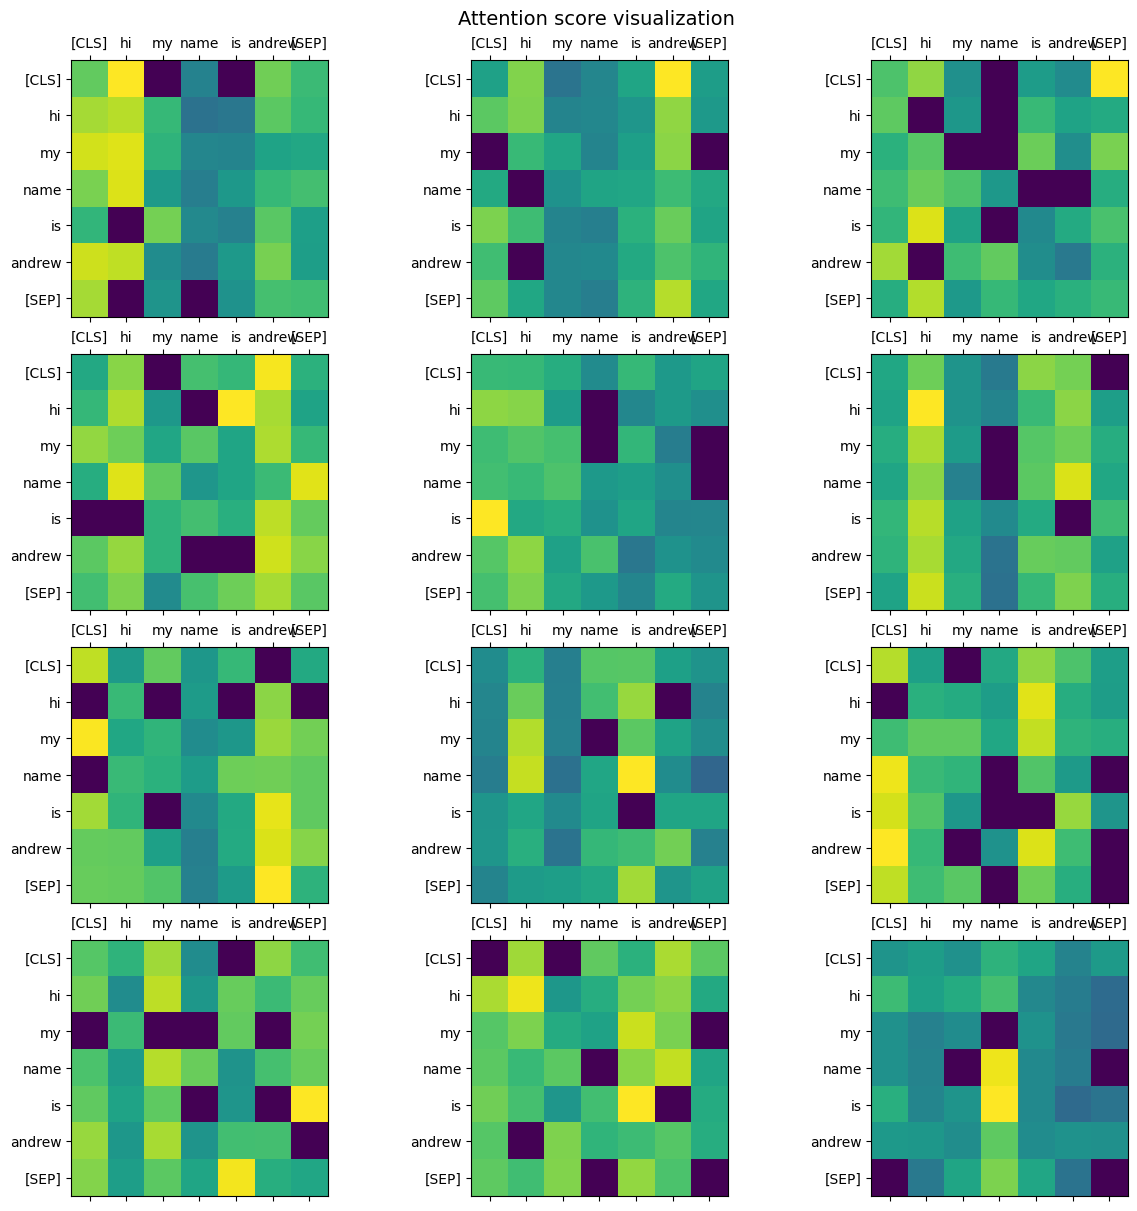

In [228]:
fig, axs = plt.subplots(4, 3, figsize=(12, 12), layout='constrained')

# plt.matshow(attention_probs[0][0].detach())

t = 0
for x in range(4):
    for y in range(3):
        ax = axs[x][y]
        ax.matshow(attention_probs[0][t].detach())
        # plt.gca().xaxis.tick_bottom()
        # ax.xaxis.tick_bottom()
        ax.set_xticks(range(len(token)), token)
        ax.set_yticks(range(len(token)), token)
        t += 1
        
fig.suptitle('Attention score visualization', fontsize=14)
plt.show()